In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import make_source_mask
from photutils.background import Background2D, BiweightLocationBackground


def display_image_SNR(imarr, binc, SNR):
    assert callable(SNRfunc), "SNR func must be callable on numpy array"
    fig,axs=plt.subplots(ncols=len(imarr), figsize=(15,4))
    Rvir = ((3*10**binc) / (4*np.pi*337*0.3*1.36e11) )**(1/3) # h=0.7 Mpc
    Rvir = (0.5*Rvir/(image_cz/70))*206265/pixel_scale # in px
    for ii,im in enumerate(imarr):
        xx=axs[ii].imshow(im,norm=LogNorm())
        axs[ii].set_title(r"S/N = {:0.2f}   $\log M_h$ = {:0.1f}".format(SNR[ii],binc[ii]))
        circle = plt.Circle((im.shape[0]//2, im.shape[1]//2), Rvir[ii], edgecolor='red', facecolor='None')
        axs[ii].add_patch(circle)
    plt.show()

# Problem: How to calculate S/N for stacked count maps?

In [2]:
stackID, nbin, bincenters, cmaps, emaps = pickle.load(open('ecostackedimages_broad_032722.pkl','rb'))
images = [ct/tim for (ct,tim) in zip(cmaps,emaps)]
#images=[im[100:200,100:200] for im in images]
Rvir = ((3*10**bincenters) / (4*np.pi*337*0.3*1.36e11) )**(1/3) # h=0.7 Mpc
pixel_scale = 45. # arcsec
image_cz = 7000. # km / s

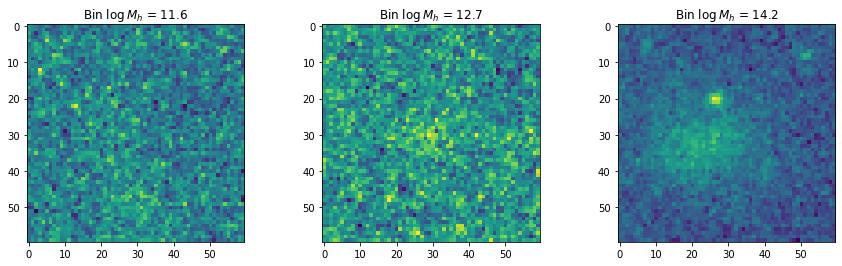

[8452, 981, 69]


In [3]:
fig,axs=plt.subplots(ncols=len(images), figsize=(15,4))
for ii,im in enumerate(images):
    axs[ii].imshow(im,norm=LogNorm())
    axs[ii].set_title(r"Bin $\log M_h$ = {:0.1f}".format(bincenters[ii]))
plt.show()
print(nbin)

# ROSAT Signal-to-Noise

In the ROSAT Observers' Guide, they define signal-to-noise as 
$$ K_{\rm SNR} = \frac{N_{\rm src}}{\sqrt{N_{\rm src}+N_b}}, $$
where $N_{\rm src}$ and $N_b$ are the *numbers* of source counts and background counts, approximating the variance in total counts as $N_{\rm src}+N_b$.

For RASS, the exposure time varies by pixel, so you need to calculate

$$ SNR = \frac{\int R_{\rm source}(A)t(A)dA}{\left[\int R_{\rm source}(A)t(A)dA + \int R_{\rm background}(A)t(A)dA\right]^{1/2}} $$
<br>
$$ SNR = \frac{\int \left[R_{\rm total}(A) - R_{\rm background}(A) \right]t(A)dA}{\left[\int R_{\rm total}(A)t(A)dA\right]^{1/2}}, $$

for:
- Source Area $A$ in Pixels
- Source counting rate $R_{\rm source}$ in cts/s/pixel
- Background counting rate $R_{\rm background}$ in cts/s/pixel
- Exposure time $t(A)$ in seconds

Background cts/sec:  0.0008463278773202034


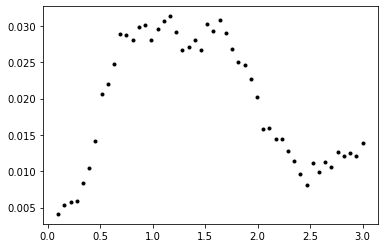

1.1653061224489796
Background cts/sec:  0.0008590136948926944


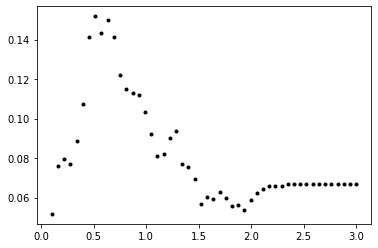

0.5142857142857142
Background cts/sec:  0.0009545467884324014


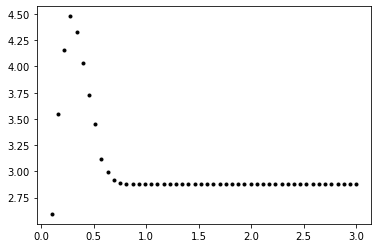

0.27755102040816326


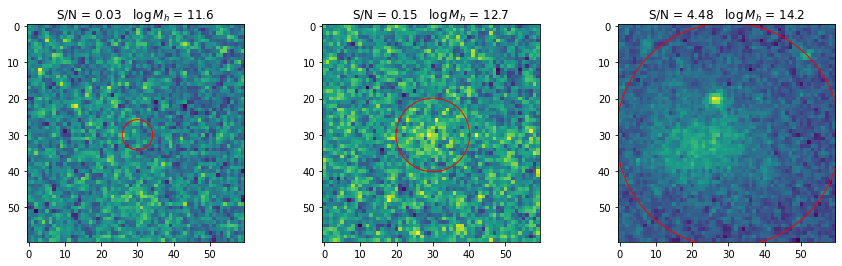

In [6]:
def SNRfunc(intensity,exposure,Rvir,sourcecenter=None):
    #intensity[17:23,25:30]=0.
    mask = make_source_mask(intensity,nsigma=2,npixels=5,dilate_size=11)
    _, bg, _ = sigma_clipped_stats(intensity,sigma=3.0,mask=mask)
    print('Background cts/sec: ', bg)
    bg = np.zeros_like(intensity)+bg
    (A1, A2) = intensity.shape
    if sourcecenter is not None:
        X,Y = np.meshgrid(np.arange(0,A1,1), np.arange(0,A2,1))
        dist_from_center = np.sqrt((X-sourcecenter[0])**2. + (Y-sourcecenter[1])**2.)
    else:
        X,Y = np.meshgrid(np.arange(0,A1,1), np.arange(0,A2,1))
        dist_from_center = np.sqrt((X-A1//2.)**2. + (Y-A2//2)**2.)
    apfrac=np.linspace(0.1,3,50)
    radius = (1*apfrac*Rvir/(image_cz/70))*206265/pixel_scale # in px
    snr=np.zeros_like(radius)*1.0
    for ii,RR in enumerate(radius):
        measuresel = (dist_from_center<RR)
        numerator = np.sum((intensity[measuresel]-bg[measuresel])*exposure[measuresel])
        denominator = np.sqrt(numerator + np.sum(bg[measuresel]*exposure[measuresel]))
        snr[ii]=numerator/denominator
    optimal_frac_of_Rvir = apfrac[np.argmax(snr)]
    plt.figure()
    plt.plot(apfrac,snr,'k.')
    plt.show()
    print(optimal_frac_of_Rvir)
    return np.max(snr)

   
SNRvals = [SNRfunc(images[ii],emaps[ii],Rvir[ii],sourcecenter=(25,25)) for ii in range(0,len(images))]
display_image_SNR(images,bincenters,SNRvals)

In [7]:
    #sigma_clip=SigmaClip(sigma=3.)
    #bkg_estimator = BiweightLocationBackground()
    #bkg = Background2D(intensity, (50,50), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    #print(bkg.background)
    #bg = bkg.background